# Trajectory Recommendation - POI Visit Duration

## 1. Overview

1. BPR ranking of POIs
1. Recommend a set of POIs given (start, end, length)
1. Recommend POI visit duration
1. Recommend visiting order

In [1]:
% matplotlib inline

import os, re, sys, time, pickle
import math, random, itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sop
from joblib import Parallel, delayed
import pymc as pm
from pymc.Matplot import plot as mcplot

In [2]:
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)

In [3]:
def print_progress(cnt, total):
    """
    Display a progress bar.
    """
    assert(cnt > 0 and total > 0 and cnt <= total)
    length = 80
    ratio = cnt / total
    n = int(length * ratio)
    sys.stdout.write('\r[%-80s] %d%%' % ('-'*n, int(ratio*100)))
    sys.stdout.flush()

In [4]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [5]:
suffix = fvisit.split('-')[-1].split('.')[0]
#fseqpart = os.path.join(data_dir, 'seqPart-' + suffix + '.pkl')

In [6]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID') # merge data frames according to column 'photoID'
#traj.head()

In [7]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


## 2.1 Compute POI Information

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [8]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [9]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [10]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
poi_all.head()
#poi_all.to_csv(fpoi, index=True)

,poiTheme,poiFreq,poiLon,poiLat
poiID,,,,
1,Sport,3506,-79.379243,43.643183
2,Sport,609,-79.418634,43.632772
3,Sport,688,-79.380045,43.662175
4,Sport,3056,-79.389290,43.641297
6,Cultural,986,-79.392396,43.653662


## 2.2 Construct Travelling Sequences

In [11]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
          .agg([np.min, np.max, np.size])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,1,0
1,10012675@N05,2,6,1142731848,1142732445,4,597
2,10012675@N05,3,6,1142916492,1142916492,1,0
3,10012675@N05,4,13,1319327174,1319332848,9,5674
4,10014440@N06,5,24,1196128621,1196128878,3,257


**Filtering out** a visit of POI with $0$ duration, i.e. only one photo was taken.

In [12]:
seq_all = seq_all[seq_all['#photo'] > 1]

In [13]:
seq_stats = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_stats.reset_index(inplace=True)
seq_stats.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
#seq_stats.head()

Start time of each sequence.

In [14]:
seq_starttime = seq_all[['userID', 'seqID', 'arrivalTime']].copy().groupby(['userID', 'seqID']).agg(np.min)
seq_starttime.reset_index(inplace=True)
seq_starttime.rename(columns={'arrivalTime':'startTime'}, inplace=True)
seq_starttime.set_index('seqID', inplace=True)
#seq_starttime.head()

In [15]:
seq_stats['startTime'] = seq_starttime.loc[seq_stats.index, 'startTime']
seq_stats.head()

,userID,seqLen,startTime
seqID,,,
2,10012675@N05,1,1142731848
4,10012675@N05,1,1319327174
5,10014440@N06,1,1196128621
6,10014440@N06,1,1198051767
7,10014440@N06,1,1198627025


In [16]:
seq_stats.shape

(2817, 3)

In [17]:
seq_stats['userID'].unique().shape

(859,)

In [18]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort_values(by=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

In [19]:
def calc_poi_info(seqid_set, seq_all, poi_all):
    poi_info = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'poiDuration(sec)']].copy()
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration(sec)', 'size':'nVisit'}, inplace=True)
    poi_info.set_index('poiID', inplace=True) 
    poi_info['poiTheme'] = poi_all.loc[poi_info.index, 'poiTheme']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    
    # POI popularity: the number of distinct users that visited the POI
    pop_df = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'userID']].copy()
    pop_df = pop_df.groupby('poiID').agg(pd.Series.nunique)
    pop_df.rename(columns={'userID':'nunique'}, inplace=True)
    poi_info['popularity'] = pop_df.loc[poi_info.index, 'nunique']
    
    return poi_info.copy()

## 2.4 Train vs. Test Data

Pick the latest trajectory for each user to form the test set, all remaining trajectories form the training set.

In [20]:
seqid_set_train = []
seqid_set_test = []

In [21]:
user_list = []

**Filtering out** users (and their trajectories) with less than $2$ trajectories.

In [22]:
for user in seq_stats['userID'].unique():
    seqid_set_u = seq_stats[seq_stats['userID'] == user].copy().sort_values(by='startTime', ascending=True)
    if seqid_set_u.shape[0] > 1:
        user_list.append(user)
        seqid_set_test.append(seqid_set_u.index.values[-1])
        seqid_set_train = seqid_set_train + seqid_set_u.index.values[:-1].tolist()

In [23]:
print('Number of trajectories for training:', len(seqid_set_train))
print('Number of trajectories for testing :', len(seqid_set_test))
print('Number of users:', len(user_list))

Number of trajectories for training: 1958
Number of trajectories for testing : 413
Number of users: 413


POIs in training/test set.

In [24]:
poi_train = seq_all[seq_all['seqID'].isin(seqid_set_train)]['poiID'].unique().tolist()
poi_test  = seq_all[seq_all['seqID'].isin(seqid_set_test)]['poiID'].unique().tolist()

In [25]:
assert(len(set(poi_test)) == len(set(poi_train) & set(poi_test)))

In [26]:
poi_list = poi_train.copy()
poi_list.sort()
print('Number of POIs:', len(poi_list))

Number of POIs: 29


## 2.5 Construct User-POI Visiting Matrix

$M_{ij}$ denotes the number of visits for user $u_i$ at POI $p_j$, $NaN$ for non-observed visits.

In [27]:
visit_cnt_df = pd.DataFrame(data=np.full((len(user_list), len(poi_list)), np.nan), columns=poi_list, index=user_list)

In [28]:
for seqid in seqid_set_train:
    user = seq_stats.loc[seqid, 'userID']
    seq = extract_seq(seqid, seq_all)
    for poi in seq:
        if np.isnan(visit_cnt_df.loc[user, poi]):
            visit_cnt_df.loc[user, poi] = 1
        else:
            visit_cnt_df.loc[user, poi] += 1

In [29]:
visit_cnt_df.head()

,1,2,3,4,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
10012675@N05,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10014440@N06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4,4,1,NaN,NaN,NaN,NaN,NaN
10502709@N05,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,2,...,2,1,1,NaN,1,NaN,3,2,NaN,NaN
10575698@N02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
10627620@N06,1,NaN,1,NaN,NaN,3,1,NaN,NaN,1,...,2,NaN,3,NaN,1,NaN,1,NaN,NaN,6


In [30]:
nan_mask = np.isnan(visit_cnt_df)
masked_visit = np.ma.masked_array(visit_cnt_df, nan_mask)

In [31]:
visits = pd.Series(masked_visit.flatten())
visits.describe()

count    1225.000000
mean        1.934694
std         4.039913
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        63.000000
dtype: float64

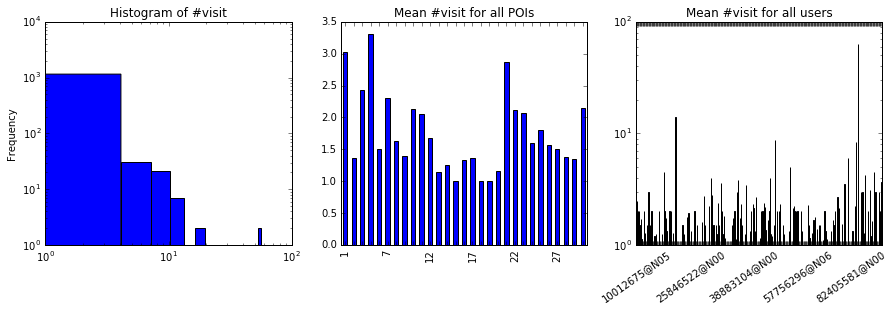

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

visits.plot(kind='hist', ax=ax1, bins=20, grid=False, title='Histogram of #visit')
ax1.set_xscale('log')
ax1.set_yscale('log')

poi_means = visit_cnt_df.mean(axis=0, skipna=True)
poi_means.plot(kind='bar', ax=ax2, grid=False, title='Mean #visit for all POIs')
xticks2 = np.arange(0, len(poi_list), 10)
plt.setp(ax2.get_xticklabels()[:], visible=False)
plt.setp(ax2.get_xticklabels()[::5], visible=True)

user_means = visit_cnt_df.mean(axis=1, skipna=True)
user_means.plot(kind='bar', ax=ax3, grid=False, title='Mean #visit for all users')
plt.setp(ax3.get_xticklabels()[:], visible=False)
plt.setp(ax3.get_xticklabels()[::90], visible=True, rotation=35)
ax3.set_yscale('log')

## 4. POI Visit Duration Prediction

In [33]:
poi_duration_df = seq_all[['userID', 'seqID', 'poiID', 'poiDuration(sec)']].copy()
poi_duration_df.set_index(['userID', 'seqID', 'poiID'], inplace=True)
poi_duration_df.head()

poiDuration(sec)
userID       seqID poiID                  
10012675@N05 2     6                   597
             4     13                 5674
10014440@N06 5     24                  257
             6     23                 1065
             7     23                  573

In [34]:
visit_duration_df = pd.DataFrame(data=np.full((len(user_list), len(poi_list)), np.nan, dtype=np.object), \
                                 columns=poi_list, index=user_list)

In [35]:
nan_mask_train = pd.DataFrame(data=np.ones(visit_duration_df.shape, dtype=np.bool), columns=poi_list, index=user_list)

In [36]:
for seqid in seqid_set_train:
    user = seq_stats.loc[seqid, 'userID']
    seq = extract_seq(seqid, seq_all)
    for poi in seq:
        duration = poi_duration_df.loc[(user, seqid, poi), 'poiDuration(sec)']
        nan_mask_train.loc[user, poi] = False
        if np.all(np.isnan(visit_duration_df.loc[user, poi])):
            visit_duration_df.loc[user, poi] = np.array([duration])
        else:
            visit_duration_df.loc[user, poi] = np.r_[visit_duration_df.loc[user, poi], duration]

In [37]:
visit_duration_df.head()

,1,2,3,4,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
10012675@N05,NaN,NaN,NaN,NaN,[597],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10014440@N06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"[1065, 573, 1615, 421]","[257, 1359, 296, 36]",[7991],NaN,NaN,NaN,NaN,NaN
10502709@N05,NaN,NaN,NaN,NaN,NaN,"[6484, 5302, 3739, 5430]",NaN,NaN,NaN,"[106, 3048]",...,"[1111, 9596]",[2164],[5133],NaN,[15776],NaN,"[242, 1354, 4622]","[17388, 335]",NaN,NaN
10575698@N02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,[3554],NaN,NaN,NaN,NaN,NaN
10627620@N06,[1723],NaN,[2989],NaN,NaN,"[434, 52, 14]",[663],NaN,NaN,[530],...,"[51, 186]",NaN,"[129, 185, 70]",NaN,[292],NaN,[11],NaN,NaN,"[3306, 1500, 19994, 21, 185, 744]"


In [38]:
visit_duration_df.iloc[2, 5]

array([6484, 5302, 3739, 5430])

### Build PMF model

In [39]:
def build_pmf(duration_df, mask, dim):
    """
    Build the Probabilistic Matrix Factorization model using pymc3.
    """
    obs_data = duration_df.copy()
    n, m = obs_data.shape
    print('obs_data:', obs_data.shape)
    print('dim:', dim)

    # Low precision reflects uncertainty; prevents overfitting.
    alpha_u = 0.01
    alpha_p = 0.01
    alpha = 1
    
    U = []
    P = []
    Obs = []
    for i in range(n):
        U_i = pm.MvNormal(str('U_%d' % i), mu=np.zeros(dim), tau=alpha_u * np.eye(dim))
        U.append(U_i)
    for j in range(m):
        P_j = pm.MvNormal(str('P_%d' % j), mu=np.zeros(dim), tau=alpha_p * np.eye(dim))
        P.append(P_j)
    for i in range(n):
        for j in range(m):
            if mask.iloc[i, j]: continue
            mu_ij = pm.sum([U[i][x] * P[j][x] for x in range(dim)])
            R_ij = pm.Normal(str('R_%d_%d' % (i, j)), mu=mu_ij, tau=alpha, observed=True, value=duration_df.iloc[i, j])
            Obs.append(R_ij)
                
    return pm.Model([x for x in U] + [x for x in P] + Obs)

In [40]:
pmf = build_pmf(visit_duration_df, nan_mask_train, dim=5)

obs_data: (413, 29)
dim: 5


### Find the MAP

In [ ]:
t0 = time.time()
map_ = pm.MAP(pmf)
map_.fit()
#map_.fit(method='fmin_powell')
print('%d seconds used.' % int(time.time() - t0))

### Run MCMC

In [ ]:
mcmc = pm.MCMC(pmf)
mcmc.sample(10000, burn=5000, thin=10)

In [ ]:
mcplot(mcmc.trace('P_5'), common_scale=False)

In [ ]:
mcmc.trace('U_0')[:].mean(axis=0)

### Compute Prediction Error

In [ ]:
def rmse(U, P, user_list, poi_list, test_tuples, seq_exp_all, poi_duration_df):
    predicted = pd.DataFrame(data=np.dot(U, P.T), columns=poi_list, index=user_list)
    #print(predicted)
    se = [] # squared errors
    for user, seqid in test_tuples:
        seq = extract_seq(seqid, seq_exp_all)
        for poi in seq:
            if (user, seqid, poi) in poi_duration_df.index:
                duration = poi_duration_df.loc[(user, seqid, poi), 'poiDuration(sec)']
                se.append(abs(duration - predicted.loc[user, poi]) ** 2)
    return math.sqrt(np.mean(se))    

In [ ]:
#U = map_estimate['U']
#P = map_estimate['P']

In [ ]:
dim = 5
U = np.zeros((len(user_list), dim), dtype=np.float)
P = np.zeros((len(poi_list), dim), dtype=np.float)
for i in range(len(user_list)):
    U[i] = mcmc.trace(str('U_%d' % i))[:].mean(axis=0)
for j in range(len(poi_list)):
    P[j] = mcmc.trace(str('P_%d' % j))[:].mean(axis=0)

In [ ]:
# Make predictions and calculate RMSE on train & test sets.
pmf_map_train_rmse = rmse(U, P, user_list, poi_list, tuples, seq_exp_all, poi_duration_df)
pmf_map_test_rmse = rmse(U, P, user_list, poi_list, user_seqid_tuples_test, seq_exp_all, poi_duration_df)
overfit = pmf_map_test_rmse - pmf_map_train_rmse

In [ ]:
print('PMF MAP training RMSE: %.5f' % pmf_map_train_rmse)
print('PMF MAP testing RMSE:  %.5f' % pmf_map_test_rmse)
print('Train/test difference: %.5f' % overfit)

### Build BPMF model

In [ ]:
def build_bpmf(duration_df, mask, dim):
    """
    Build the original BPMF model
    """
    obs_data = duration_df.copy()
    n, m = obs_data.shape
    alpha = 0.01 # low precision means high variance
    print('obs_data:', obs_data.shape)
    print('dim:', dim)
    
    # user feature hyperparameters
    lambda_u = pm.Wishart('lambda_u', n=dim, Tau=np.eye(dim))
    mu_u = pm.Normal('mu_u', mu=0, tau=1, size=dim)
    
    # POI feature hyperparameters
    lambda_p = pm.Wishart('lambda_p', n=dim, Tau=np.eye(dim))
    mu_p = pm.Normal('mu_p', mu=0, tau=1, size=dim)
    
    # user feature matrix
    U = []
    for i in range(n): 
        U_i = pm.MvNormal(str('U_%d' % i), mu=mu_u, tau=lambda_u)
        U.append(U_i)
    
    # POI feature matrix
    P = []
    for j in range(m): 
        P_j = pm.MvNormal(str('P_%d' % j), mu=mu_p, tau=lambda_p)
        P.append(P_j)
    
    # observations
    Obs = []
    for i in range(n): 
        for j in range(m):
            if mask.iloc[i, j]: continue
            mu_ij = pm.sum([U[i][x] * P[j][x] for x in range(dim)])
            R_ij = pm.Normal(str('R_%d_%d' % (i,j)), mu=mu_ij, tau=alpha, observed=True, value=duration_df.iloc[i,j])
            Obs.append(R_ij)
            
    return pm.Model([lambda_u, mu_u, lambda_p, mu_p] + U + P + Obs)

In [ ]:
bpmf = build_bpmf(visit_duration_df, nan_mask_train, dim=5)

### Find the MAP

In [ ]:
t0 = time.time()
map_ = pm.MAP(bpmf)
map_.fit()
#map_.fit(method='fmin_powell')
print('%d seconds used.' % int(time.time() - t0))

### Run MCMC

In [ ]:
mcmc = pm.MCMC(bpmf)
mcmc.sample(10000000, burn=5000000, thin=100)

In [ ]:
mcplot(mcmc.trace('mu_u'), common_scale=False)

In [ ]:
mcplot(mcmc.trace('mu_p'), common_scale=False)

In [ ]:
mcplot(mcmc.trace('P_2'), common_scale=False)